In [44]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Is this notebook running on Colab or Kaggle?
IS_COLAB = "google.colab" in sys.modules
IS_KAGGLE = "kaggle_secrets" in sys.modules

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "classification"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)
    
    
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = mpl.cm.binary,
               interpolation="nearest")
    plt.axis("off")

In [2]:
from sklearn.datasets import fetch_openml

# import MNIST dataset
mnist = fetch_openml('mnist_784', version=1)

# print the keys of the dataset
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets loaded by Scikit-Learn have a dictionary structure:
* A **DESCR** key describing the dataset.
* A **data** key containing a dataframe (as_frame=False for array) with one row per instance and once column per feature.
* A **target** key containing a series with the labels.

In [3]:
import numpy as np

# assign data to X and target to y
X, y = mnist["data"], mnist["target"]

# print the shape of X and y
X.shape, y.shape

# convert X and y to arrays
X = X.values
y = y.values

# check their type
type(X), type(y)

(numpy.ndarray, pandas.core.arrays.categorical.Categorical)

There are 70,000 images (rows) and 784 features (columns). 

Each feature represents 1 pixel's intensity (1 image = 28 x 28 pixels), from 0 (white) to 255 (black).

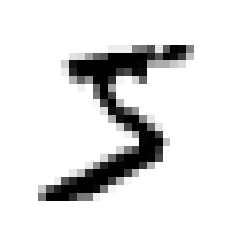

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# check one digit from the dataset
some_digit = X[0]

# reshape image to 28 x 28 for a more intuitive representation
some_digit_image = some_digit.reshape(28, 28)

# show image
plt.imshow(some_digit_image, cmap='binary')
plt.axis("off")
plt.show()

In [5]:
# check its label
y[0]

'5'

Notice that y is of type object.

In [6]:
# check the data type of y
type(y)

pandas.core.arrays.categorical.Categorical

More info on numpy data types [here](https://numpy.org/doc/stable/user/basics.types.html).

In [7]:
# convert y to integer
y = y.astype(np.uint8)

# check type of the y array
y.dtype

dtype('uint8')

Split the data into test and training sets.

In [8]:
# assign 60_000 rows for training and 10_000 for testing
X_train, X_test, y_train, y_test = X[:60_000], X[60_000:], y[:60_000], y[60_000:]

<a name="BinaryClassification"> </a>
# Training a Binary Classifier

Train the **5-detector**, capable of distinguishing between just 2 classes: 5 and not-5.

In [9]:
# True for all 5s, False for all others
y_train_5 = (y_train == 5)

y_test_5 = (y_test == 5)

In [10]:
# train a Stochastic Gradient Descent (SGD) Classifier
from sklearn.linear_model import SGDClassifier

# create an SGDC instance
sgd_clf = SGDClassifier(random_state=42)

# fit SGDC on training data
sgd_clf.fit(X_train, y_train_5)

# make predictions
sgd_clf.predict([some_digit])

array([ True])

This was indeed a 5!

In [11]:
y[0]

5

<a name="PerfMeasures"> </a>
# Performance Measures

In [12]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred == y_test_fold)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [13]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Check vs. **Null Accuracy**, i.e. always predict that is not a 5.

In [14]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y=None):
        return self
    def predict(self, X):
        return np.zeros((len(X), 1), dtype=bool)
    
never_5_clf = Never5Classifier()

cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.91125, 0.90855, 0.90915])

Only 10% are 5s, thus, its is right 90% of the time! This is why **accuracy** is generally **not the preferred performance measure for classifiers**, in particular for *skewed datasets*.

<a name="ConfusionMatrix"> </a>
# Confusion Matrix

In [15]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

```cross_val_predict()``` performs K-fold CV, but instead of returning the evaluation scores like ```cross_val_score```, it **returns the predictions** made on each test fold.

In [16]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred), recall_score(y_train_5, y_train_pred)

(0.8370879772350012, 0.6511713705958311)

In [18]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

In [19]:
y_scores = sgd_clf.decision_function([some_digit])
print(y_scores)

threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

[2164.22030239]


array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

Use ```cross_val_predict()``` for choosing which threshold to use.

In [21]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                            method="decision_function")

Use ```precision_recall_curve()``` to compute precision and recall scores for all possible thresholds.

In [22]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

Plot decision and recall as functions of the threshold value.

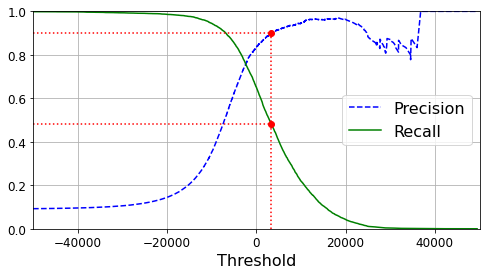

Saving figure precision_recall_vs_threshold_plot


<Figure size 432x288 with 0 Axes>

In [23]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    #fig, ax = plt.subplots(figsize=(15,5))
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend(loc="center right", fontsize=16)
    plt.xlabel("Threshold", fontsize=16)
    plt.grid(True)
    plt.axis([-50000, 50000, 0, 1])

    
recall_90_precision = recalls[np.argmax(precisions >= 0.90)]
threshold_90_precision = thresholds[np.argmax(precisions >= 0.90)]


plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [0.9, 0.9], "r:")
plt.plot([-50000, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
plt.plot([threshold_90_precision], [0.9], "ro")
plt.plot([threshold_90_precision], [recall_90_precision], "ro")

plt.show()
    
save_fig("precision_recall_vs_threshold_plot")

Saving figure roc_curve_plot


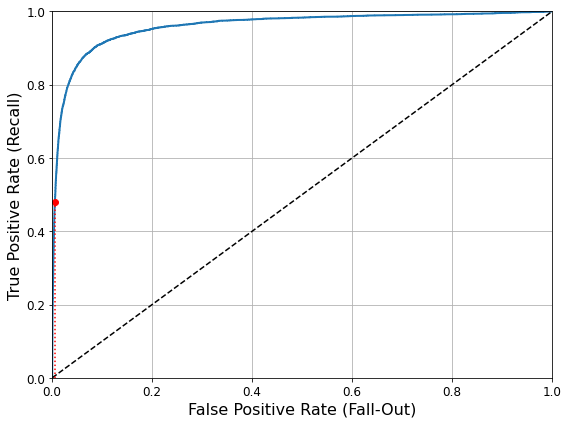

In [24]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--') # dashed diagonal
    plt.axis([0, 1, 0, 1])                                    # Not shown
    plt.xlabel('False Positive Rate (Fall-Out)', fontsize=16) # Not shown
    plt.ylabel('True Positive Rate (Recall)', fontsize=16)    # Not shown
    plt.grid(True)                                            # Not shown

plt.figure(figsize=(8, 6))                                    # Not shown
plot_roc_curve(fpr, tpr)
fpr_90 = fpr[np.argmax(tpr >= recall_90_precision)]           # Not shown
plt.plot([fpr_90, fpr_90], [0., recall_90_precision], "r:")   # Not shown
plt.plot([0.0, fpr_90], [recall_90_precision, recall_90_precision], "r:")  # Not shown
plt.plot([fpr_90], [recall_90_precision], "ro")               # Not shown
save_fig("roc_curve_plot")                                    # Not shown
plt.show()

In [25]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

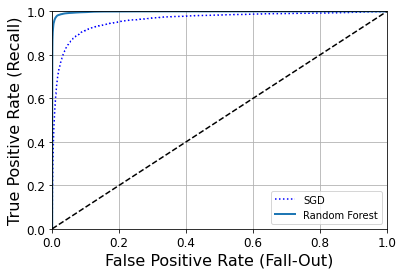

In [26]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)

y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3,
                                   method="predict_proba")

y_scores_forest = y_probas_forest[:, 1] # score = prba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="lower right")
plt.show()

In [27]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

<a name="MulticlassClassification"> </a>
# Multiclass Classification

In [29]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto", random_state=42)
svm_clf.fit(X_train[:1000], y_train[:1000]) # y_train, not y_train_5
svm_clf.predict([some_digit])

array([5], dtype=uint8)

In [30]:
some_digit_scores = svm_clf.decision_function([some_digit])

# it returns 10 scores per instance instead of 1
print(some_digit_scores)

# returns the index of the winning class
print(np.argmax(some_digit_scores))

# the classes of our dataset
print(svm_clf.classes_)

# return the value of the winning index 
print(svm_clf.classes_[5])

[[ 2.81585438  7.09167958  3.82972099  0.79365551  5.8885703   9.29718395
   1.79862509  8.10392157 -0.228207    4.83753243]]
5
[0 1 2 3 4 5 6 7 8 9]
5


# Create a multiclass classifier using the OvR strategy based on an SVC.

In [31]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())

ovr_clf.fit(X_train, y_train)

print(ovr_clf.predict([some_digit]))

print(len(ovr_clf.estimators_))

[5]
10


Training an SGDClassifier.

In [35]:
sgd_clf.fit(X_train, y_train)

print(sgd_clf.predict([some_digit]))

# returns 1 value per class because SGDs can directly classify instances into multiple classes
print(sgd_clf.decision_function([some_digit]))

[3]
[[-31893.03095419 -34419.69069632  -9530.63950739   1823.73154031
  -22320.14822878  -1385.80478895 -26188.91070951 -16147.51323997
   -4604.35491274 -12050.767298  ]]


In [36]:
# evalute SGDC
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [37]:
# simply scaling the inputs
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring='accuracy')

array([0.8983, 0.891 , 0.9018])

<a name="ErrorAnalysis"> </a>
# Error Analysis

In [38]:
# check the confusion matrix
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]],
      dtype=int64)

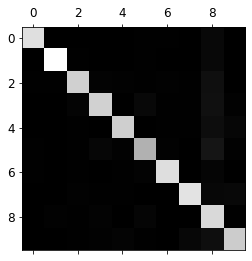

In [39]:
plt.matshow(conf_mx, cmap=plt.cm.gray)
plt.show()

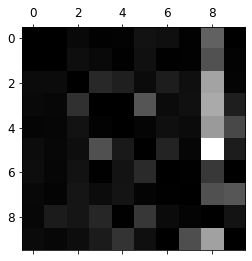

In [40]:
row_sums = conf_mx.sum(axis=1, keepdims=True)
norm_conf_mx = conf_mx / row_sums

# fill the diagonal with 0s to keep only the errors
np.fill_diagonal(norm_conf_mx, 0)
# plot the results
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)

plt.show()

<a name="MultilabelClassification"> </a>
# Multilabel Classification

A classification system that outputs multiple binary tags.

In [41]:
from sklearn.neighbors import KNeighborsClassifier

# classify the digit as large if it is >=7
y_train_large = (y_train >= 7)

# classify the digit as odd if % 2 == 1
y_train_odd = (y_train % 2 == 1)

# assign two labels per class (is it large? is it odd?)
y_multilabel = np.c_[y_train_large, y_train_odd]

# create a kNC instance (supports multilabel classification)
knn_clf = KNeighborsClassifier()

# fit kNC to our training data
knn_clf.fit(X_train, y_multilabel)

# predict the first digit, i.e., 5
knn_clf.predict([some_digit])

array([[False,  True]])

In [42]:
# predict using CV
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_multilabel, cv=3)

# calcualte f1 score across all labels
f1_score(y_multilabel, y_train_knn_pred, average='macro')

0.976410265560605

<a name="Multioutput Classification"> </a>
# Multioutput Classification

A generalization of the multilabel classification where each label can be multiclass (it can have more than two possible values).

Saving figure noisy_digit_example_plot


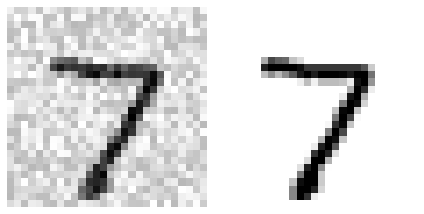

In [45]:
# add noise to the MNIST images
noise = np.random.randint(0, 100, (len(X_train), 784))

X_train_mod = X_train + noise

noise = np.random.randint(0, 100, (len(X_test), 784))

X_test_mod = X_test + noise

y_train_mod = X_train

y_test_mod = X_test

# peek at a noisy image from the test set
some_index = 0
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

save_fig("noisy_digit_example_plot")
plt.show()

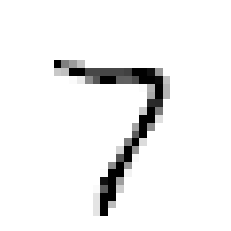

In [46]:
# use classifier to clean the above image
knn_clf.fit(X_train_mod, y_train_mod)

clean_digit = knn_clf.predict([X_test_mod[some_index]])

plot_digit(clean_digit)